#**Milestone 2**

In [5]:
# It is recommended to upgrade the statsmodels library. 
# Uncomment the below code to upgrade statsmodels
!pip install statsmodels --upgrade

In [6]:
import pandas as pd
import warnings
import itertools
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [7]:
#to ignore warnings
import warnings
import itertools
warnings.filterwarnings("ignore")

In [8]:
df = pd.read_excel('MER_T12_06.xlsx')
df.head()

,MSN,YYYYMM,Value,Description
0,CLEIEUS,197301,72.076,Coal Electric Power Sector CO2 Emissions
1,CLEIEUS,197302,64.442,Coal Electric Power Sector CO2 Emissions
2,CLEIEUS,197303,64.084,Coal Electric Power Sector CO2 Emissions
3,CLEIEUS,197304,60.842,Coal Electric Power Sector CO2 Emissions
4,CLEIEUS,197305,61.798,Coal Electric Power Sector CO2 Emissions


In [9]:
#conversion of "YYYYMM" columnn into standard datetime format & making it as index
# We are using errors=’coerce’. It will replace all non-numeric values with NaN.

dateparse = lambda x: pd.to_datetime(x, format='%Y%m', errors = 'coerce')
df = pd.read_excel('MER_T12_06.xlsx', parse_dates=['YYYYMM'], index_col='YYYYMM', date_parser=dateparse) 
df.head()

,MSN,Value,Description
YYYYMM,,,
1973-01-01,CLEIEUS,72.076,Coal Electric Power Sector CO2 Emissions
1973-02-01,CLEIEUS,64.442,Coal Electric Power Sector CO2 Emissions
1973-03-01,CLEIEUS,64.084,Coal Electric Power Sector CO2 Emissions
1973-04-01,CLEIEUS,60.842,Coal Electric Power Sector CO2 Emissions
1973-05-01,CLEIEUS,61.798,Coal Electric Power Sector CO2 Emissions


**The arguments can be explained as:**

- **parse_dates:** This is a key to identify the date time column. Example, the column name is ‘YYYYMM’.
- **index_col:** This is a key that forces pandas to use the date time column as index.
- **date_parser:** Converts an input string into datetime variable.

- Let us first identify and **drop the non datetimeindex** rows. First, let's convert the index to datetime, coerce errors, and filter NaT

In [10]:
ts = df[pd.Series(pd.to_datetime(df.index, errors='coerce')).notnull().values]
ts.head()
ts.describe().T

,count,unique,top,freq
MSN,4707,9,CLEIEUS,523
Value,4707,3284,Not Available,384
Description,4707,9,Coal Electric Power Sector CO2 Emissions,523


**Observations**
1. The observations have reduced to 4707 after filtering on NaT
2. There are 9 unique categories in MSN and Description columns
3. The 'Value' coulmn has missing values with a high frequency of 384. The rows with these missing values should be eliminated

In [11]:
#convert the emision value into numeric value
nat=pd.DataFrame(pd.to_numeric(ts['Value'],errors='coerce')).convert_dtypes()
ts['Value']=nat['Value']

In [12]:
#Drop the missing value using dropna(inplace = True)
ts.dropna(inplace = True)
ts.describe().T

,count,mean,std,min,25%,50%,75%,max
Value,4323.0,39.252449,61.128676,0.009,0.73,6.236,40.638,247.995


In [13]:
ts.dtypes

MSN             object
Value          Float64
Description     object
dtype: object

### **Natural gas based CO2 emission forecasting**

For developing the time series model and forecasting, you are expected to use the natural gas CO2 emission from the electrical power generation. We need to slice this data:

In [14]:
###Slice the data to get the monthly total CO2 emissions of Natural Gas Electric Power Sector
natural=ts[ts['MSN']=='NNEIEUS']
natural= pd.DataFrame(natural).drop(['Description','MSN'],axis=1)

In [15]:
 #Check 1st few rows of data
natural.head()

,Value
YYYYMM,
1973-01-01,12.175
1973-02-01,11.708
1973-03-01,13.994
1973-04-01,14.627
1973-05-01,17.344


###**Split the dataset**

In [16]:
# Split the data into train and test
# using first 34 years data as training data
train_data = natural.loc['1973-01-01':'2007-11-01']

# using the last 9 years data as test data
test_data = natural.loc['2007-12-01':'2016-07-01']
print(train_data)
print(test_data)

             Value
YYYYMM            
1973-01-01  12.175
1973-02-01  11.708
1973-03-01  13.994
1973-04-01  14.627
1973-05-01  17.344
...            ...
2007-07-01    41.3
2007-08-01  52.659
2007-09-01  37.094
2007-10-01    32.8
2007-11-01  24.335

[419 rows x 1 columns]
             Value
YYYYMM            
2007-12-01  27.056
2008-01-01  28.901
2008-02-01  23.864
2008-03-01  25.045
2008-04-01  25.512
...            ...
2016-03-01  40.525
2016-04-01  39.763
2016-05-01   44.21
2016-06-01  53.567
2016-07-01  62.881

[104 rows x 1 columns]


###**Test the Stationarity**

In [17]:
#Import the required package

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

###**Test the stationarity through Visualization**

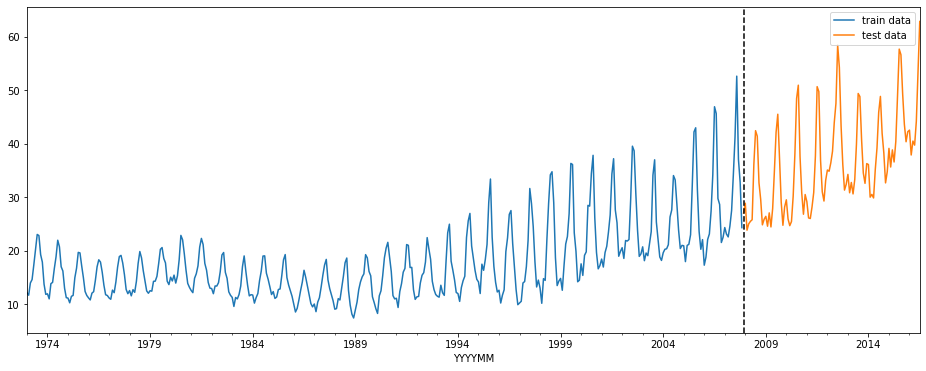

In [18]:
# creating a subplot space
fig, ax = plt.subplots(figsize=(16, 6))

# plotting train data
train_data.plot(ax=ax)

# plotting test data
test_data.plot(ax=ax)

# adding the legends in sequential order
plt.legend(['train data', 'test data'])

# showing the time which divides the original data into train and test
plt.axvline(x='2007-12-01', color='black', linestyle='--')

# showing the plot
plt.show()

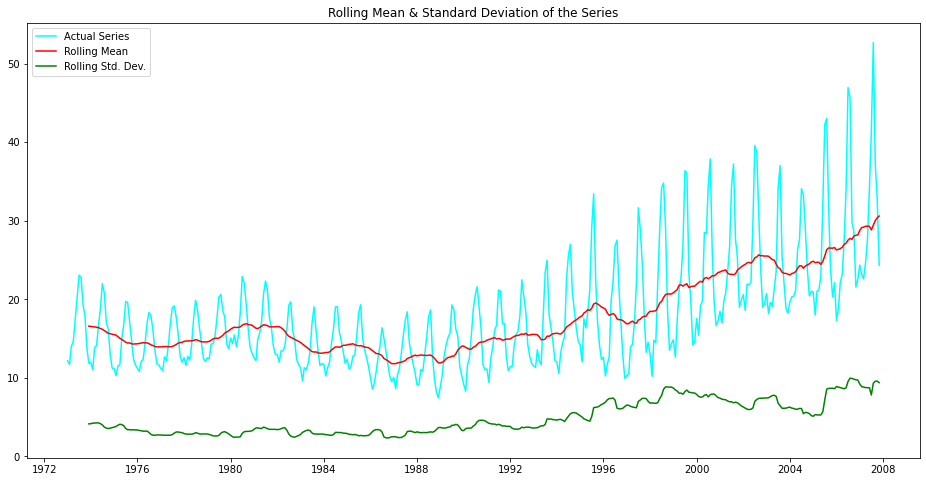

In [19]:
# Calculate the rolling mean and standard deviation for a window of 12 observations
rolmean=train_data.rolling(window=12).mean()
rolstd=train_data.rolling(window=12).std()

# Visualize the rolling mean and standard deviation
plt.figure(figsize=(16,8))
actual = plt.plot(train_data, color='cyan', label='Actual Series')
rollingmean = plt.plot(rolmean, color='red', label='Rolling Mean') 
rollingstd = plt.plot(rolstd, color='green', label='Rolling Std. Dev.')
plt.title('Rolling Mean & Standard Deviation of the Series')
plt.legend()
plt.show()

#### **Observations and Insights: ____**
1. Series has upward trend, it is not stationary

### **Test the stationarity using the Augmented Dickey-Fuller Test**

Use the **Augmented Dickey-Fuller (ADF) Test** to verify if the series is stationary or not. The null and alternate hypotheses for the ADF Test are defined as:

**- Null hypothesis:** The Time Series is non-stationary


**- Alternative hypothesis:** The Time Series is stationary

In [20]:
#Define a function to use adfuller test
def adfuller(train_data):
  #Importing adfuller using statsmodels
  from statsmodels.tsa.stattools import adfuller
  print('Dickey-Fuller Test: ')
  adftest = adfuller(train_data['Value'])
  adfoutput = pd.Series(adftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Observations'])
  for key,value in adftest[4].items():
    adfoutput['Critical Value (%s)'%key] = value
  print(adfoutput)
adfuller(train_data)

Dickey-Fuller Test: 
Test Statistic            1.159067
p-value                   0.995691
Lags Used                17.000000
No. of Observations     401.000000
Critical Value (1%)      -3.446763
Critical Value (5%)      -2.868775
Critical Value (10%)     -2.570624
dtype: float64


- **Observations and Insights**
 
Observations:

1. From the above test, we can see that the p-value = 0.995 i.e. > 0.05 (For 95% confidence intervals) therefore, we fail to reject the null hypothesis.
2. Hence, we can confirm that the series is non-stationary.

###**Transformation of the dataset into a stationary one**

**We can use some of the following methods to convert a non-stationary series into a stationary one:**


1. Log Transformation
2. Differencing the series (lagged series)

We take the average of ‘k’ consecutive values depending on the frequency of time series (in this capstone 12 months). 

Here, we will take the average over the past 1 year.

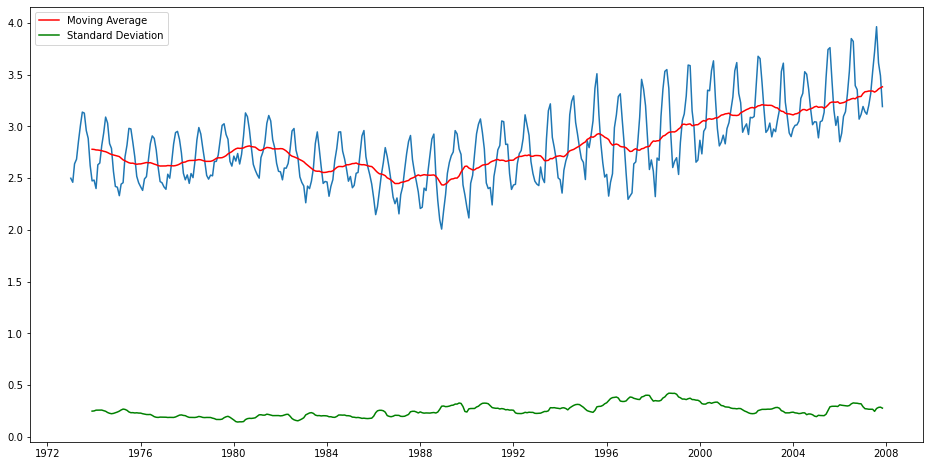

In [21]:
 # Visualize the rolling mean and standard deviation after using log transformation
plt.figure(figsize=(16,8))
df_log = np.log(train_data) #Reduced variance
MAvg = df_log.rolling(window=12).mean()
MStd = df_log.rolling(window=12).std()
plt.plot(df_log)
plt.plot(MAvg, color='r', label = 'Moving Average')
plt.plot(MStd, color='g', label = 'Standard Deviation')
plt.legend()
plt.show()

**Observations and Insights: _____**
- Since **we can still see the upward trend in the series**, we can conclude that **the series is still non-stationary.** 
- However, the standard deviation is almost constant which implies that **now the series has constant variance.**

**Visualize the rolling mean and rolling standard deviation of the shifted series (df_shift) and check the stationarity by calling the adfuller() function. Also, write your observations on the same.**

No handles with labels found to put in legend.


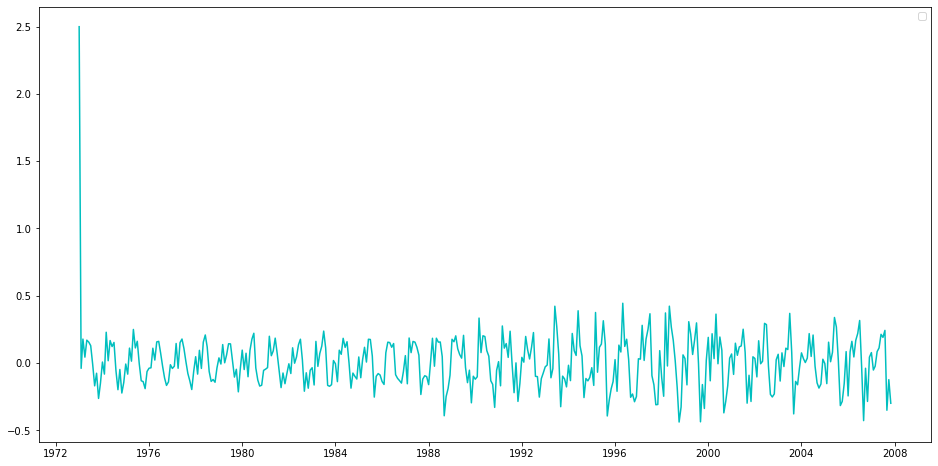

In [22]:
plt.figure(figsize=(16,8))
df_shift = df_log - df_log.shift(periods = 1,fill_value=0)
MAvg_shift = df_shift.rolling(window=12).mean()
MStd_shift = df_shift.rolling(window=12).std()
plt.plot(df_shift, color='c')
#plt.plot(MAvg_shift, color='red', label = 'Moving Average')
#plt.plot(MStd_shift, color='green', label = 'Standard Deviation')
plt.legend()
plt.show()

#Dropping the null values that we get after applying differencing method
df_shift = df_shift.dropna()

**Observations and Insights:___**
1.Since we can no longer see an upward trend, the series seems to be alomonst constant (stationary)

2. The standard deviation also seems to be almost constant

Lets verify using Augmented Dickey-Fuller (ADF) Test

In [23]:
adfuller(df_shift)

Dickey-Fuller Test: 
Test Statistic         -5.694135e+00
p-value                 7.945779e-07
Lags Used               1.600000e+01
No. of Observations     4.020000e+02
Critical Value (1%)    -3.446722e+00
Critical Value (5%)    -2.868757e+00
Critical Value (10%)   -2.570614e+00
dtype: float64


**Observations and Insights: _____**
1. From the above test, we can see that the p-value = 5.447548e-14 i.e. < 0.05 (For 95% confidence intervals) therefore, we can reject the null hypothesis.
2. Hence, we can confirm that the series is now stationary.



# Obtaining stationarity through differencing##

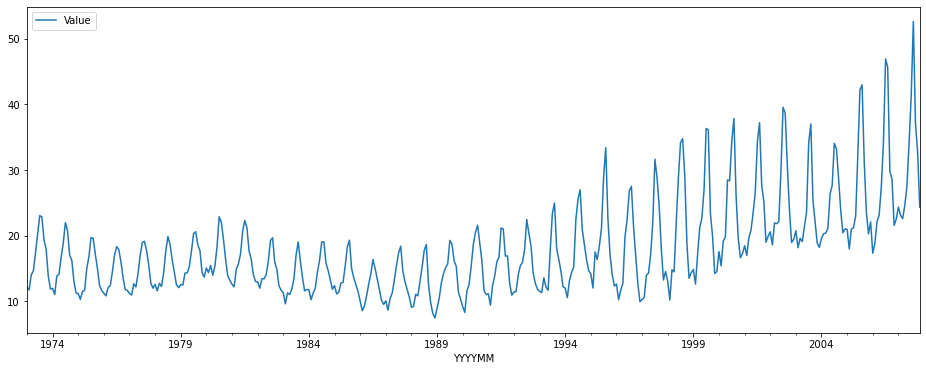

ADF Statistic: 1.1590670915803927
p-value: 0.9956905071284862


In [24]:
from statsmodels.tsa.stattools import adfuller
# implementing ADF test on the original time series data
result = adfuller(train_data['Value'])

fig, ax = plt.subplots(figsize=(16, 6))
train_data.plot(ax=ax)
plt.show()

# printing the results
print('ADF Statistic:', result[0])
print('p-value:', result[1])

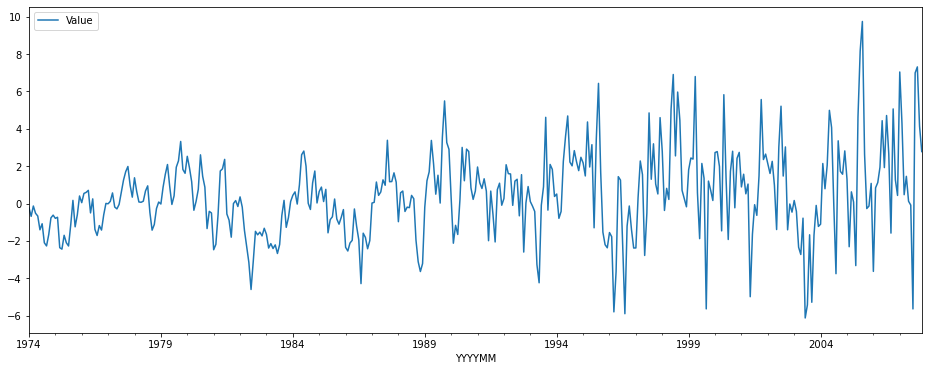

ADF Statistic: -4.470975725397112
p-value: 0.00022179961185728872


In [25]:
# taking seasonal differencing of the timeseries
train_data_stationary = train_data.diff(periods=12).dropna()

# implementing ADF test on the first order differenced time series data
result = adfuller(train_data_stationary['Value'])

fig, ax = plt.subplots(figsize=(16, 6))
train_data_stationary.plot(ax=ax)
plt.show()

# printing the results
print('ADF Statistic:', result[0])
print('p-value:', result[1])

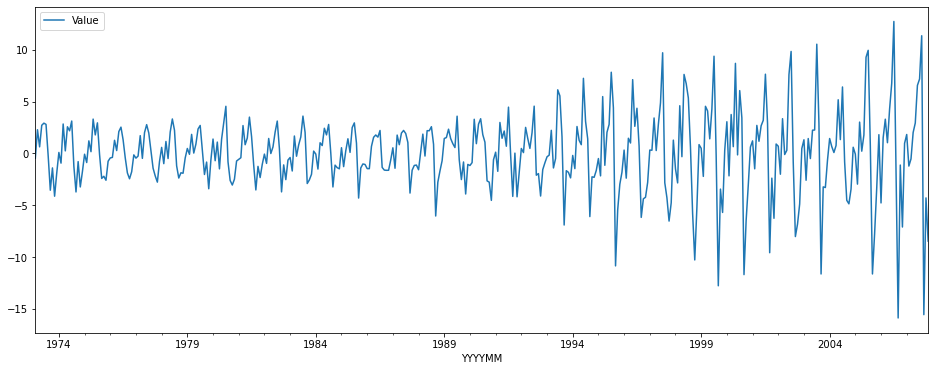

ADF Statistic: -4.21427431898197
p-value: 0.0006231846832304005


In [26]:
# taking 1st order differencing of the timeseries
train_data_stationary = train_data.diff().dropna()

# implementing ADF test on the first order differenced time series data
result = adfuller(train_data_stationary['Value'])

fig, ax = plt.subplots(figsize=(16, 6))
train_data_stationary.plot(ax=ax)
plt.show()

# printing the results
print('ADF Statistic:', result[0])
print('p-value:', result[1])

**Observations and Insights: _____**
1. p-value=0.00062<0.05. Stationarity is obtained by 1st order differencing. Therefore d=1 in ARIMA modelling

Let's decompose the time series to check its different components.

### **Elimination of trend and seasonality: Decomposition**

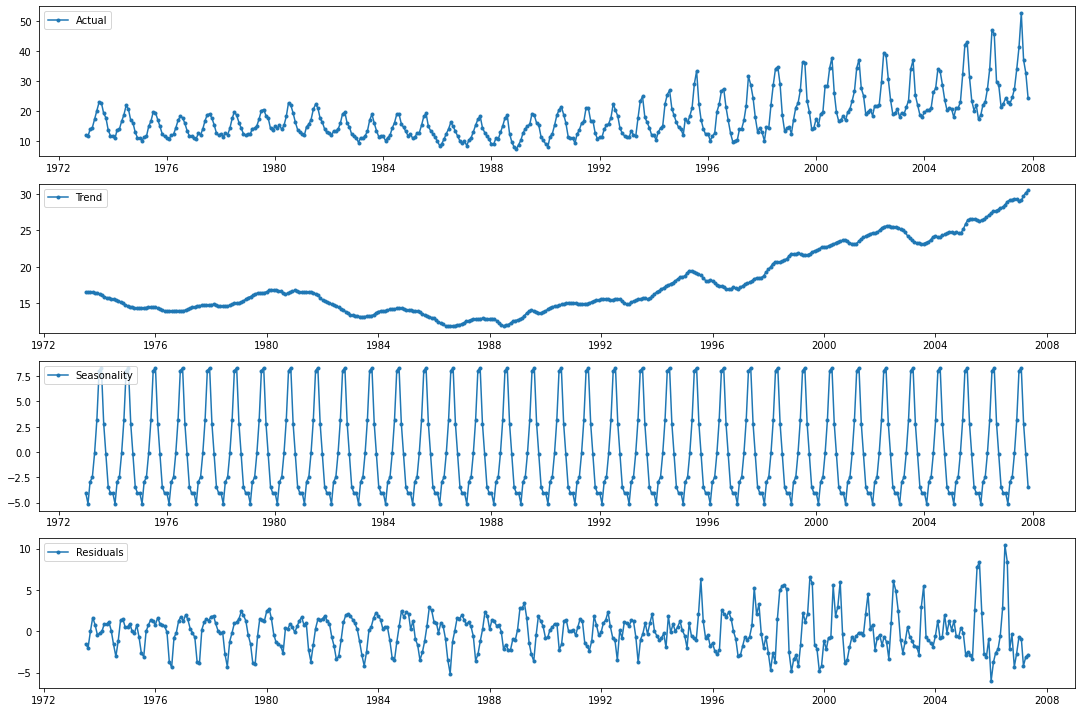

In [27]:
#Importing the seasonal_decompose function to decompose the time series

from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(train_data)

trend = decomp.trend
seasonal = decomp.seasonal
residual = decomp.resid

plt.figure(figsize=(15,10))
plt.subplot(411)
plt.plot(train_data, label='Actual', marker='.')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', marker='.')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality', marker='.')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals', marker='.')
plt.legend(loc='upper left')
plt.tight_layout()

**Observations and Insights: ____**
- We can see that there are significant **trend, seasonality and residuals components** in the series
- The plot for seasonality shows that **Natural gas based CO2 emissions spike in July and August.**

**Now let's move on to the model building section. First, we will plot the `ACF` and `PACF` plots to get the values of p and q i.e. order of AR and MA models to be used.**

**Plot the auto-correlation function and partial auto-correlation function to get p and q values for AR, MA, ARMA, and ARIMA models**

### **Find optimal parameters (P, Q) and build the AR, MA, ARMA & ARIMA models**

**Plot the ACF and PACF charts and find the optimal parameters**

<Figure size 1152x576 with 0 Axes>

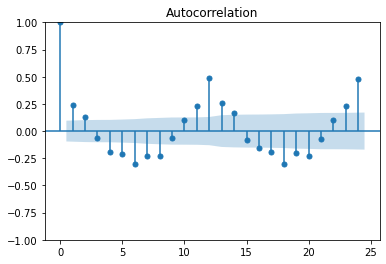

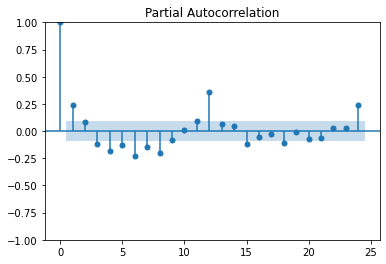

In [28]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

plt.figure(figsize = (16,8))
plot_acf(df_shift, lags = 24) 
plt.show() 
plot_pacf(df_shift, lags = 24) 
plt.show()

**Observations and Insights: _____**

**Observations:**
- From the above PACF plot we can see that **the lag** at which the plot extends beyond the statistically significant boundary for the first time is **lag 1.** 
- This indicates that an **AR Model of lag 1 (p=1)** should be sufficient to fit the data.
- Similarly, from the ACF plot, we can infer that **q=1.**
- The ACF and PACF also capture the seasonality in the data




###**AR Model**

Order p is the lag value after which the PACF plot crosses the upper confidence interval for the first time. These p lags will act as our features while forecasting the AR time series.

Fit and predict the shifted series with the AR Model and calculate the RMSE. Also, visualize the time series and write your observations.

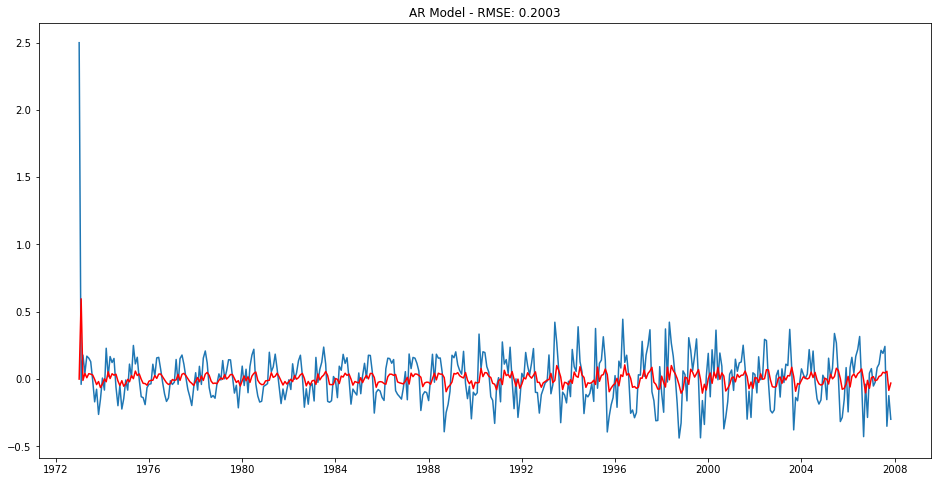

In [29]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error

plt.figure(figsize=(16,8))
model_AR = AutoReg(df_shift.astype(float), lags=1)#Use number of lags as 1 and apply AutoReg function on df_shift series
results_AR = model_AR.fit() #fit the model
plt.plot(df_shift)
predict = results_AR.predict() #predict the series 
predict = predict.fillna(0) #Converting NaN values to 0
plt.plot(predict, color='red')
plt.title('AR Model - RMSE: %.4f'% mean_squared_error(predict,df_shift['Value'], squared=False))  #Calculating rmse
plt.show()

**Observations & Insights: _____**
**Observations:________________________**
1. The RMSE value is 0.2. It is very less. Therefore,this is a good model if we only want to use the AR component while modeling.
2.The time series appears stationary

**Let's check the AIC value** of the model

In [30]:
results_AR.aic

-345.1651192683715

Now, let's build MA, ARMA, and ARIMA models as well, and see if we can get a better model 

###**MA Model**

####**Think about it:**

- Do we really have to find AR & I value other than 0 to forecast on the MA based model?

Order q of the MA process is obtained from the ACF plot, this is the lag after which ACF crosses the upper confidence interval for the first time.

Fit and predict the shifted series with the MA Model and calculate the RMSE. Also, visualize the time series and write your observations.

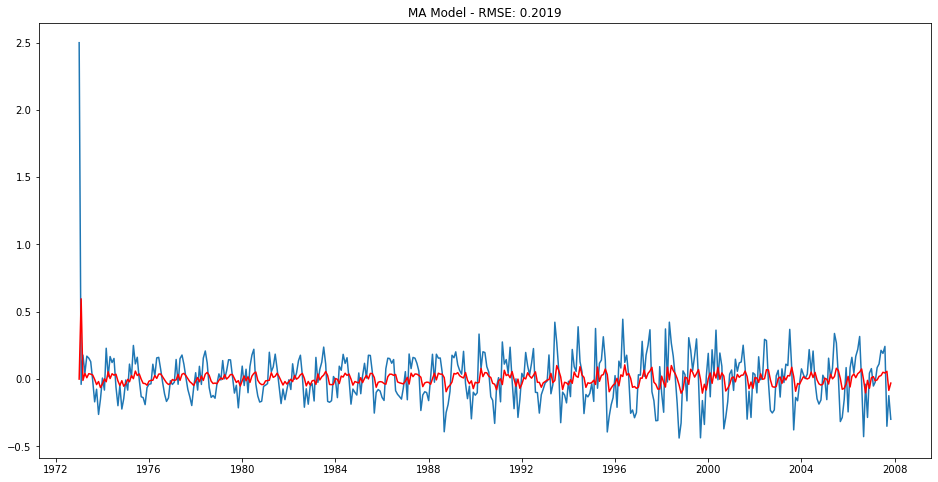

In [31]:
from statsmodels.tsa.arima.model import ARIMA

plt.figure(figsize=(16,8))
model_MA =ARIMA(df_shift.astype(float), order=(0,0,1))#Using p=0, d=0, q=1 and apply ARIMA function on df_shift series
results_MA = model_MA.fit()#fit the model
plt.plot(df_shift)
predict1 = results_MA.predict() #predict the series 
predict1 = predict1.fillna(0) 
plt.plot(predict, color='red')
plt.title('MA Model - RMSE: %.4f'% mean_squared_error(results_MA.fittedvalues,df_shift['Value'], squared=False))
plt.show()

**Observations & Insights: _____**
**Observations:________________________**
1. THE RMSE is 0.2. Similar to AutoReg AR model. We need to check AIC value to determine if MA model is better than AR model for forecasting
2. The time series appears stationary

Let's check the AIC value of the model

In [32]:
results_MA.aic

-157.22602661876954

- **The MA model is giving higher AIC** when compared to the AR model, implying that **the AR model fits the training data better.** 

###**ARMA MODEL**

**We will be using the above AR lag(P) & MA lag(Q) as a paramter** and d=0 in ARIMA so that it will work as an ARMA model.

Fit and predict the shifted series with the ARMA Model and calculate the RMSE. Also, visualize the time series and write your observations.

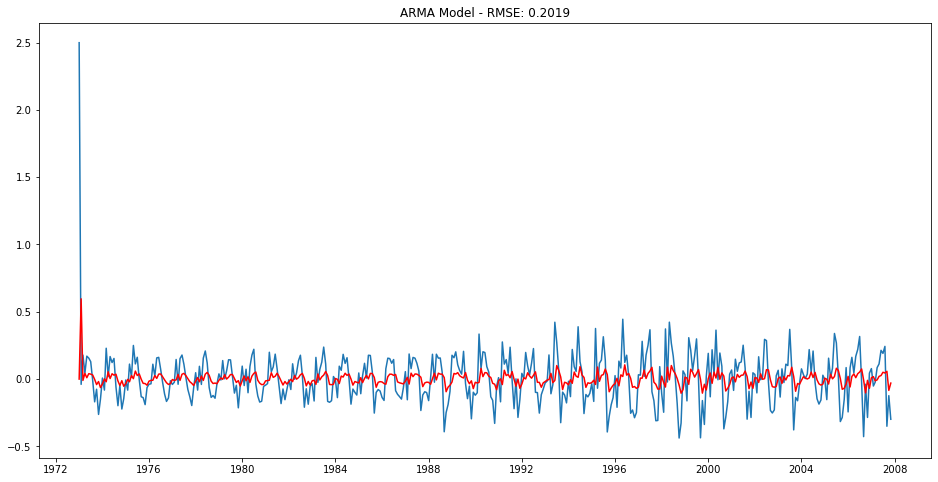

In [33]:
#Code here
plt.figure(figsize=(16,8))
model_ARMA =ARIMA(df_shift.astype(float), order=(1,0,1)) #Using p=1, d=0, q=1 and apply ARIMA function on df_shift series
results_ARMA =model_MA.fit() #fit the model
plt.plot(df_shift)
predict2 = results_MA.predict() #predict the series 
predict2 = predict2.fillna(0) 
plt.plot(predict, color='red')
plt.title('ARMA Model - RMSE: %.4f'% mean_squared_error(results_ARMA.fittedvalues,df_shift['Value'], squared=False))
plt.show()



**Observations & Insights: _____**
**Observations:**
1. THE RMSE is 0.0902. Similar to AutoReg AR model and MA(0,0,1) model
2.The time series appears stationary.


**Let's check the AIC value** of the model

**Check the AIC value of the model**

In [34]:
#Code here
results_ARMA.aic

-157.22602661876954

- **The AIC value of the ARMA model is more or less similar** to MA model 

**Let us try using the ARIMA Model.**

###**ARIMA MODEL**

**Fit and predict the shifted series with the ARIMA Model and calculate the RMSE. Also, visualize the time series and write your observations.**

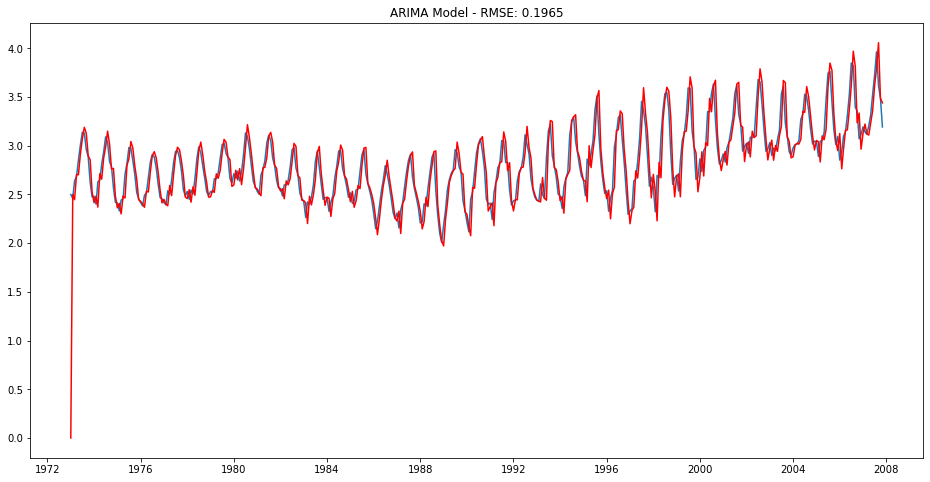

In [35]:
#Code here
from statsmodels.tsa.arima.model import ARIMA

plt.figure(figsize=(16,8))
model_ARIMA = ARIMA(df_log.astype(float), order=(1,1,1))#Using p=1, d=1, q=1 and apply ARIMA function on df_log series
results_ARIMA = model_ARIMA.fit()#fit the model
plt.plot(df_log)
predict3 = results_ARIMA.predict() #predict the series 
predict3 = predict3.fillna(0)
plt.plot(predict3, color='red')
plt.title('ARIMA Model - RMSE: %.4f'% mean_squared_error(results_ARIMA.fittedvalues,df_log['Value'], squared=False))
plt.show()

**Observations:________**
1. The RMSE value is 0.1965, lesser than previous models. The predicted values fit the data very well

**Let's check the AIC value** of the model

**Check the AIC value of the model**

In [36]:
results_ARIMA.aic

-370.59427283572046

From the above analysis, we can see that the ARIMA(1, 1, 1) is the best model as compared to others, as it has less RMSE as compared to all the other models. 

###**Inverse Transformation**

**Use the correct inverse transformation depending on the model chosen to get back the original values.**



**Apply an inverse transformation on the predictions of the chosen model**

In [37]:
# Printing the fitted values
predictions=pd.Series(results_ARIMA.fittedvalues)
predictions

YYYYMM
1973-01-01    0.000000
1973-02-01    2.499385
1973-03-01    2.445545
1973-04-01    2.704176
1973-05-01    2.701914
                ...   
2007-07-01    3.610796
2007-08-01    3.794965
2007-09-01    4.056922
2007-10-01    3.487274
2007-11-01    3.439726
Length: 419, dtype: float64

In [38]:
#Third step - applying exponential transformation
predictions_ARIMA = np.exp(predictions)#use exponential function
predictions_ARIMA

YYYYMM
1973-01-01     1.000000
1973-02-01    12.175000
1973-03-01    11.536835
1973-04-01    14.942001
1973-05-01    14.908244
                ...    
2007-07-01    36.995483
2007-08-01    44.476663
2007-09-01    57.796156
2007-10-01    32.696694
2007-11-01    31.178403
Length: 419, dtype: float64

**Plot the original vs predicted series**

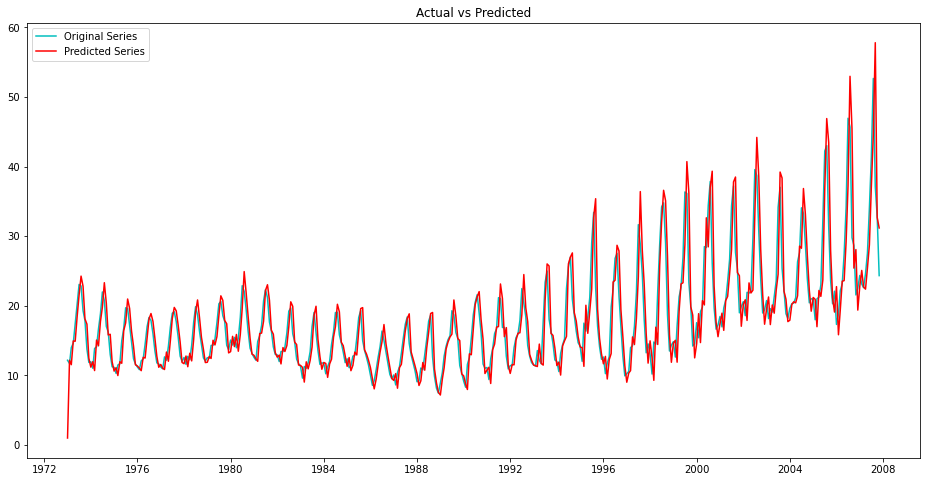

In [39]:
#Code here
#Plotting the original vs predicted series
plt.figure(figsize=(16,8))
plt.plot(train_data, color = 'c', label = 'Original Series')  #plot the original train series
plt.plot(predictions_ARIMA, color = 'r', label = 'Predicted Series')  #plot the predictions_ARIMA 
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

**Observations & Insights: _____**
 We can see that **the predicted series is very similar to the original series** i.e. The model is good at predicting values on the training data.
- Let us **forecast the closing prices for the next 24 months.**

###**Forecast the values for next 24 months and compare it with test data**

In [40]:
#Add the code blocks based on the requirements
forecasted_ARIMA = results_ARIMA.forecast(steps=24)#forecast using the results_ARIMA for next 24 months. Keep steps=24
forecasted_ARIMA

2007-12-01    3.079178
2008-01-01    3.032832
2008-02-01    3.013779
2008-03-01    3.005947
2008-04-01    3.002727
2008-05-01    3.001403
2008-06-01    3.000859
2008-07-01    3.000635
2008-08-01    3.000543
2008-09-01    3.000506
2008-10-01    3.000490
2008-11-01    3.000484
2008-12-01    3.000481
2009-01-01    3.000480
2009-02-01    3.000479
2009-03-01    3.000479
2009-04-01    3.000479
2009-05-01    3.000479
2009-06-01    3.000479
2009-07-01    3.000479
2009-08-01    3.000479
2009-09-01    3.000479
2009-10-01    3.000479
2009-11-01    3.000479
Freq: MS, Name: predicted_mean, dtype: float64

In [41]:
list1 = forecasted_ARIMA.tolist()
series1 = pd.Series(list1)
series1

0     3.079178
1     3.032832
2     3.013779
3     3.005947
4     3.002727
5     3.001403
6     3.000859
7     3.000635
8     3.000543
9     3.000506
10    3.000490
11    3.000484
12    3.000481
13    3.000480
14    3.000479
15    3.000479
16    3.000479
17    3.000479
18    3.000479
19    3.000479
20    3.000479
21    3.000479
22    3.000479
23    3.000479
dtype: float64

In [42]:
index = pd.date_range('2007-12-01','2009-12-01' , freq='1M')- pd.offsets.MonthBegin(1)
df1 = pd.DataFrame()
df1['forecasted'] = np.exp(series1)
df1.index = index
df1

,forecasted
2007-12-01,21.740524
2008-01-01,20.755929
2008-02-01,20.364216
2008-03-01,20.205337
2008-04-01,20.140382
2008-05-01,20.113740
2008-06-01,20.102798
2008-07-01,20.098301
2008-08-01,20.096453
2008-09-01,20.095693


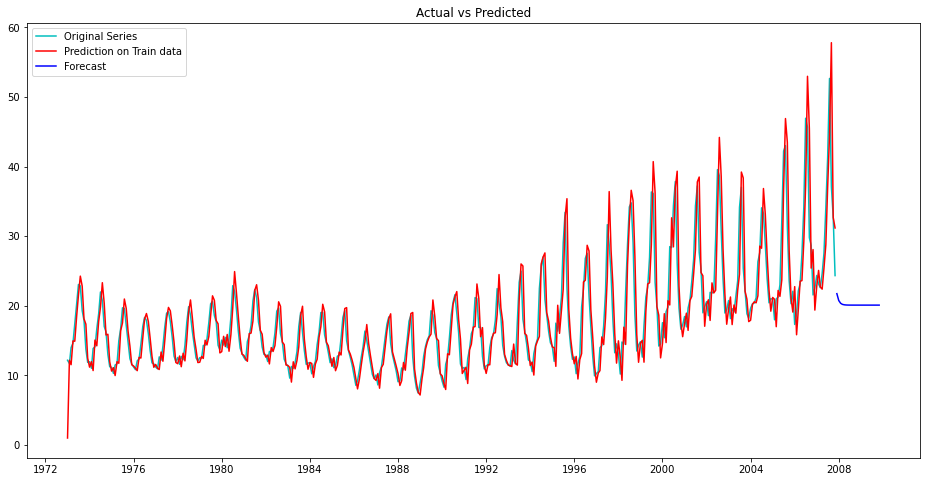

In [43]:
#Plotting the original vs predicted series
plt.figure(figsize=(16,8))
plt.plot(train_data, color = 'c', label = 'Original Series')
plt.plot(predictions_ARIMA, color = 'r', label = 'Prediction on Train data') #plot the predictions_ARIMA series
plt.plot(df1, label = 'Forecast', color='b')  #plot the forecasted_ARIMA series
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

**Observations:**
- **As observed earlier, most of the predicted values on the training data are very close to the actual values** 
- **The model does not capture seasonalities in the data**, therefore the forecasted values are not able to identify these seasonalities and therefore not close to the actual data

Let's test the RMSE of the transformed predictions and the original value on the training and testing data to check whether the model is giving a generalized performance or not.

In [44]:
from sklearn.metrics import mean_squared_error
error =np.sqrt(mean_squared_error(predictions_ARIMA, train_data)) #calculate RMSE using the predictions_ARIMA and df_train 
error

3.455270663099523

In [45]:
from sklearn.metrics import mean_squared_error
error = np.sqrt(mean_squared_error(forecasted_ARIMA, test_data.iloc[0:24,:]))
error#calculate RMSE using the forecasted_ARIMA and df_test

28.349472295374053

####**Think about it:**
- Can we use other than RMSE measurement to check the performance of the model?

####**Think about it:**

 Can we use other forecasting methods such as SARIMA to improve our model performance?

- [A Gentle Introduction to SARIMA for Time Series Forecasting in Python](https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/)
- [Forecasting with Seasonal ARIMA in Python](https://www.datasciencecentral.com/profiles/blogs/tutorial-forecasting-with-seasonal-arima)

## **Proposed Approach**

####**Refined insights**:
- What are the most meaningful insights from the data relevant to the problem?
1. The CO2 emissions due to Natural gas have an increasing trend. The time series also consists of seasonalities (with peak emissions in the months of July, Sepetember) and residuals

####**Comparison of various techniques and their relative performance**:
- How do different techniques perform? Which one is performing relatively better? Is there scope to improve the performance further?
1. The ARIMA (1,1,1) fits better than all models. The RMSE value is lower than AR,MA and ARMA models. However, AIC values of MA and ARMA models are lower than all models
2. ARIMA model could not forecast CO2 emissions taking the seasonalities into account. THerfore, SARIMA would be better at identifying seasonalities in the forecasted values

####**Proposal for the final solution design**:
- What model do you propose to be adopted? Why is this the best solution to adopt?
1. I would obtain ACF and PACF plots of the stationary data (After turning non-stationary data to stationary)
2. I would obtain p and q values from the PACF and ACF plots respectively
3. I would use SARIMA model to fit the training data and forecast the next 24 months. This model should be able to identify seasonalities in the forecasted data

In [46]:
import itertools
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score

In [47]:
# Define the p, d and q parameters to take any value between 0 and 3
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA: ')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA: 
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [48]:
# Determing p,d,q combinations with AIC scores.
for param in pdq:
    for param_seasonal in seasonal_pdq:
        mod = sm.tsa.statespace.SARIMAX(df_log.astype(float),
                                        order=param,
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=False,enforce_invertibility=False)

        results = mod.fit(disp=0)

        print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:2060.9157662807424
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1506.6750888795455
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:-517.2947515734645
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:-515.3666050010388
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:-524.5415941579959
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:-553.3318185604853
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:-517.3379008731423
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:-515.0009860478924
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1511.2631030616706
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:997.9810016405556
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:-677.1602333741203
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:-698.7625959220759
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:-683.1804440526586
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:-740.7134090260604
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:-699.3623240255234
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:-698.3508134935267
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:-309.3047489984266
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:-463.1591919

-858.66
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6063      0.051     11.983      0.000       0.507       0.705
ma.L1         -0.9148      0.031    -29.089      0.000      -0.976      -0.853
ar.S.L12       1.0034      0.007    151.320      0.000       0.990       1.016
ma.S.L12      -0.8016      0.036    -22.007      0.000      -0.873      -0.730
sigma2         0.0066      0.000     15.298      0.000       0.006       0.007


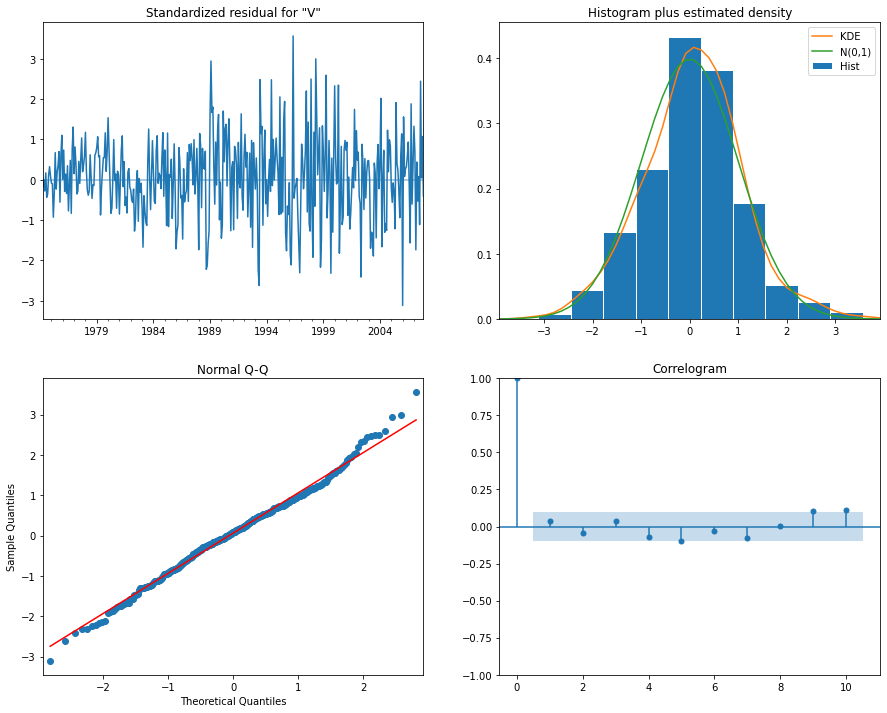

In [49]:
mod = sm.tsa.statespace.SARIMAX(df_log.astype(float),
                                order=(1, 1, 1),
                                seasonal_order=(1, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit(disp=0)

print(round(results.aic,2))
print(results.summary().tables[1])
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [50]:
# Printing the fitted values
predictions=pd.Series(results.fittedvalues)
predictions

YYYYMM
1973-01-01    0.000000
1973-02-01    3.257059
1973-03-01    2.436559
1973-04-01    2.746764
1973-05-01    2.709692
                ...   
2007-07-01    3.811094
2007-08-01    3.765486
2007-09-01    3.609620
2007-10-01    3.403220
2007-11-01    3.224915
Length: 419, dtype: float64

In [51]:
#Third step - applying exponential transformation
predictions_SARIMA = np.exp(predictions)#use exponential function
predictions_SARIMA

YYYYMM
1973-01-01     1.000000
1973-02-01    25.973042
1973-03-01    11.433630
1973-04-01    15.592096
1973-05-01    15.024642
                ...    
2007-07-01    45.199841
2007-08-01    43.184692
2007-09-01    36.951999
2007-10-01    30.060729
2007-11-01    25.151443
Length: 419, dtype: float64

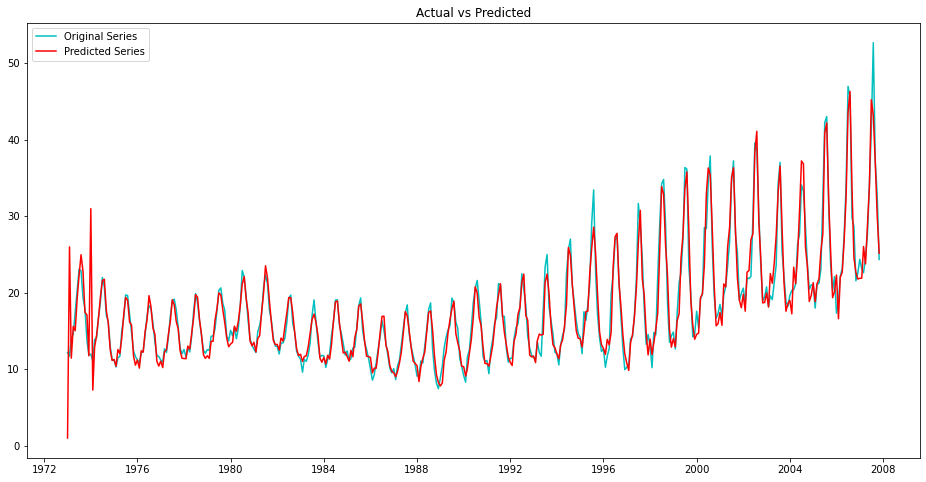

In [52]:
#Code here
#Plotting the original vs predicted series
plt.figure(figsize=(16,8))
plt.plot(train_data, color = 'c', label = 'Original Series')  #plot the original train series
plt.plot(predictions_SARIMA, color = 'r', label = 'Predicted Series')  #plot the predictions_ARIMA 
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

In [53]:
#Add the code blocks based on the requirements
forecasted_SARIMA = results.forecast(steps=24)#forecast using the results_ARIMA for next 24 months. Keep steps=24
forecasted_SARIMA

2007-12-01    3.195912
2008-01-01    3.187906
2008-02-01    3.119107
2008-03-01    3.238633
2008-04-01    3.278864
2008-05-01    3.425018
2008-06-01    3.622685
2008-07-01    3.881412
2008-08-01    3.940709
2008-09-01    3.619621
2008-10-01    3.447571
2008-11-01    3.208963
2008-12-01    3.225719
2009-01-01    3.225412
2009-02-01    3.161061
2009-03-01    3.283838
2009-04-01    3.325930
2009-05-01    3.473630
2009-06-01    3.672610
2009-07-01    3.932609
2009-08-01    3.992343
2009-09-01    3.670293
2009-10-01    3.497737
2009-11-01    3.258361
Freq: MS, Name: predicted_mean, dtype: float64

In [54]:
list2 = forecasted_SARIMA.tolist()
series2 = pd.Series(list2)
series2

0     3.195912
1     3.187906
2     3.119107
3     3.238633
4     3.278864
5     3.425018
6     3.622685
7     3.881412
8     3.940709
9     3.619621
10    3.447571
11    3.208963
12    3.225719
13    3.225412
14    3.161061
15    3.283838
16    3.325930
17    3.473630
18    3.672610
19    3.932609
20    3.992343
21    3.670293
22    3.497737
23    3.258361
dtype: float64

In [55]:
index = pd.date_range('2007-12-01','2009-12-01' , freq='1M')- pd.offsets.MonthBegin(1)
df2 = pd.DataFrame()
df2['forecasted'] = np.exp(series2)
df2.index = index
df2

,forecasted
2007-12-01,24.432455
2008-01-01,24.237622
2008-02-01,22.626163
2008-03-01,25.498840
2008-04-01,26.545599
2008-05-01,30.723208
2008-06-01,37.437957
2008-07-01,48.492622
2008-08-01,51.455084
2008-09-01,37.323435


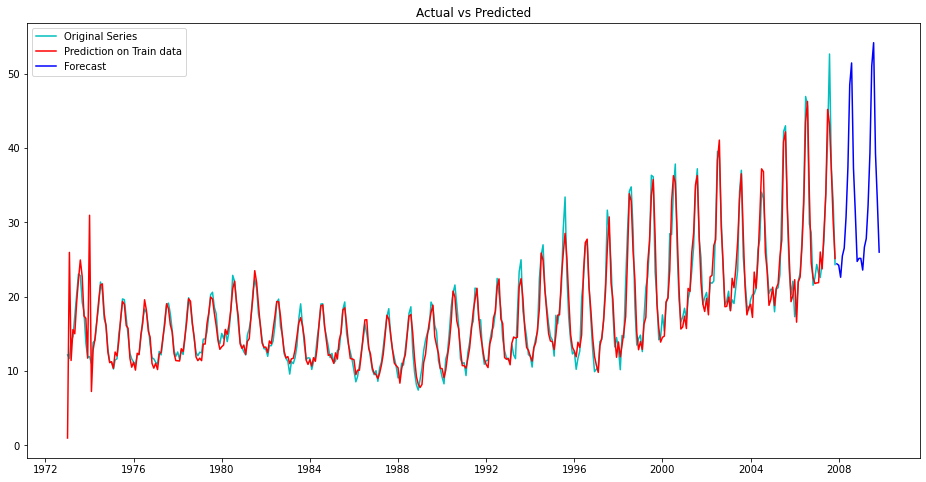

In [56]:
#Plotting the original vs predicted series
plt.figure(figsize=(16,8))
plt.plot(train_data, color = 'c', label = 'Original Series')
plt.plot(predictions_SARIMA, color = 'r', label = 'Prediction on Train data') #plot the predictions_ARIMA series
plt.plot(df2, label = 'Forecast', color='b')  #plot the forecasted_ARIMA series
plt.title('Actual vs Predicted')
plt.legend()
plt.show()